In [191]:
using StatsBase, StatsFuns, Distributions, PyPlot, JuMP, Gurobi
include("BernsteinEstimate_MD.jl")
n= 100;
#Y = rand(Gamma(3,2), n);
#Y = rand(MixtureModel(Normal[Normal(2.0, 1.0),Normal(-3.0, 1)], [0.3, 0.7]), n);
Y = rand(MixtureModel(Normal[Normal(2.0, 1.0),Normal(-1.0, 1.0), Normal(-5.0,1.0)], [0.3, 0.4,  0.3]), n);


In [192]:
a = -10.0
b = 10.0

m = 100 + 1

M = Model(solver = GurobiSolver(TimeLimit = 600))

@variable(M, w[1:m]>=0)
@variable(M, z[1:m-1], Bin)
@variable(M, σ_plus[1:m-2], Bin)
@variable(M, σ_minus[1:m-2], Bin)
@variable(M, α[1:m-2,1:2], Bin)

setvalue(w, BernsteinEstimate_MD(Y,m,a,b,0)')

@constraint(M, sum(w)==1);

In [193]:
# A big constant
K = 100
# k-modality constraint
k = 2
for j=1:m-1
    @constraint(M, w[j]<=w[j+1]+K*z[j]);
    @constraint(M, w[j]>=w[j+1]-K*(1-z[j]));
end
for j=1:m-2
    @constraint(M, z[j+1]-z[j]==σ_plus[j]-σ_minus[j]);
    @constraint(M, σ_plus[j]<=K*α[j,1]);
    @constraint(M, σ_minus[j]<=K*α[j,2]);
    @constraint(M, α[j,1]+α[j,2]==1);
end
@constraint(M, sum(σ_plus)<=k);
@constraint(M, sum(σ_minus)<=k-1);

In [194]:
ϵ = 3/(8*n)
Ecdf = ecdf(Y)

L = zeros(n,n)
B = zeros(n,m)
f = zeros(n,1)
for i = 1:n 
    L[i,i] = (n/((Ecdf(Y[i])+ϵ)*(1+ϵ-Ecdf(Y[i]))))^0.5 
    f[i] = Ecdf(Y[i])
end
for i=1:n
    for j=1:m
        B[i,j] = betacdf(j, m-j+1, (Y[i]-a)/(b-a))
    end
end

@variable(M, r[1:n])
@constraint(M, r.==L*(f-B*w))
 
@objective(M, Min, sum(r.^2))
#@objective(M, Min, sum(w'*(B'*L*B)*w-2*f'*L*B*w+f'*L*f))

:Min

In [195]:
tic()
solve(M)
toc()

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Optimize a model with 3499 rows, 3497 columns and 161934 nonzeros
Model has 500 quadratic objective terms
Coefficient statistics:
  Matrix range    [1e-13, 8e+02]
  Objective range [0e+00, 0e+00]
  Bounds range    [1e+00, 1e+00]
  RHS range       [9e-01, 8e+02]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 1.32592e+06
Presolve removed 998 rows and 998 columns
Presolve time: 0.24s
Presolved: 2501 rows, 2499 columns, 153172 nonzeros
Presolved model has 500 quadratic objective terms

MIP start did not produce a new incumbent solution

Variable types: 1001 continuous, 1498 integer (1498 binary)

Root relaxation: objective 1.868756e+01, 18648 iterations, 1.59 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

 

600.078625944

In [196]:
w_hat=getvalue(w)
D = 1000;
x = linspace(a,b,D);
y1 = zeros(D,1);
y1 = y1[:,1];
y2 = zeros(D,1);
y2 = y2[:,1];
y3 = zeros(D,1);
y3 = y3[:,1];
y4 = zeros(D,1);
y4 = y4[:,1];
y5 = zeros(D,1);
y5 = y5[:,1];

tic()
w_hat0 = BernsteinEstimate_MD(Y,m,a,b,0)'
toc()
tic()
w_hat2 = BernsteinEstimate_MD(Y,m,a,b,2)'
toc()

for i = 1:D
    #y1[i] = pdf(Gamma(3,2),x[i]);
    #y1[i] = pdf(MixtureModel(Normal[Normal(2.0, 1.0),Normal(-3.0, 1)], [0.3, 0.7]),x[i]);
    y1[i] = pdf(MixtureModel(Normal[Normal(2.0, 1.0),Normal(-1.0, 1), Normal(-5,1)], [0.3, 0.4, 0.3]), x[i])
    y5[i] = pdf(MixtureModel(Normal[Normal(-3.7332,2.016),Normal(1.8621,0.9222)], [0.7,0.3]),x[i])
    for j = 1:m
        y2[i] = y2[i]+w_hat[j]*betapdf(j, m-j+1, (x[i]-a)/(b-a))/(b-a);
        y3[i] = y3[i]+w_hat0[j]*betapdf(j, m-j+1, (x[i]-a)/(b-a))/(b-a);
        y4[i] = y4[i]+w_hat2[j]*betapdf(j, m-j+1, (x[i]-a)/(b-a))/(b-a);
    end
end

elapsed time: 7.05011435 seconds
elapsed time: 437.807995731 seconds


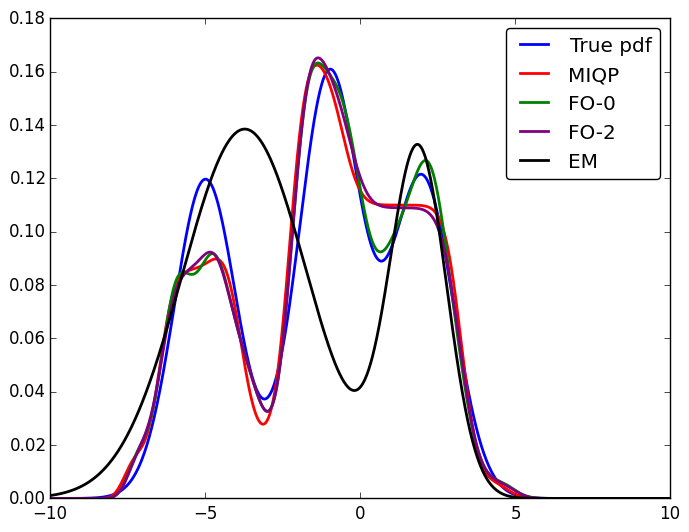

PyObject <matplotlib.legend.Legend object at 0x00000000310ACDD8>

In [197]:
plot(x, y1, color="blue", linewidth=2.0, label="True pdf")
plot(x, y2, color="red", linewidth=2.0, label="MIQP")
plot(x, y3, color="green", linewidth=2.0, label="FO-0")
plot(x, y4, color="purple", linewidth=2.0, label="FO-2")
plot(x, y5, color="black", linewidth=2.0, label="EM")

legend(loc="upper right",fancybox="true")

In [198]:
mean(abs(y2-y1))

0.006825098964494417

In [199]:
mean(abs(y3-y1))

0.00502847905206392

In [200]:
mean(abs(y4-y1))

0.006012875749743392

In [201]:
mean(abs(y5-y1))

0.022008361868037143